In [22]:
import os
import random
import math
import warnings
from random import randint
from tqdm import tqdm

import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from scipy import linalg, stats
from scipy.interpolate import make_interp_spline
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn import mixture, linear_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from sklearn.decomposition import PCA
                    
import torch
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Optimizer
from torchcam.methods import GradCAM, GradCAMpp
from torchcam.utils import overlay_mask
import torch.optim as optim
from torch.nn import DataParallel
from PIL import Image
import copy

# plt.rcParams['figure.dpi'] = 300
device = torch.device('cuda:0')
# warnings.filterwarnings("ignore", category=FutureWarning)

In [23]:
def non_iid_mnist_split_pytorch(num_clients=20, samples_per_label=250, original_clients=100):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(mnist_train, batch_size=len(mnist_train), shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size=len(mnist_test), shuffle=False)
    x_train, y_train = next(iter(train_loader)); x_test, y_test = next(iter(test_loader))

    idx_label = {i: [] for i in range(10)}
    for idx, label in enumerate(y_train):
        idx_label[label.item()].append(idx)

    client_data_train = {i: [] for i in range(num_clients)}
    for i in range(original_clients):
        chosen_labels = [(i*2)%10, (i*2+1)%10]
        chosen_indices = []
        for label in chosen_labels:
            if len(idx_label[label]) < samples_per_label:
                idx_label[label] = list(torch.where(y_train == label)[0].cpu().numpy())
            label_indices = idx_label[label][:samples_per_label]
            chosen_indices.extend(label_indices)
            idx_label[label] = idx_label[label][samples_per_label:]
        client_indices_tensor = torch.tensor(chosen_indices, dtype=torch.long)
        client_id = i // (original_clients // num_clients)
        if not client_data_train[client_id]:
            for _ in range(5):
                client_data_train[client_id].append(([], []))
        client_data_train[client_id][i % 5][0].append(x_train[client_indices_tensor])
        client_data_train[client_id][i % 5][1].append(y_train[client_indices_tensor])

    for client_id in range(num_clients):
        for time_id in range(5):
            client_data_train[client_id][time_id] = (
                torch.cat(client_data_train[client_id][time_id][0], dim=0),
                torch.cat(client_data_train[client_id][time_id][1], dim=0))

    client_data_test = (x_test, y_test)
    return client_data_train, client_data_test

client_data_train, client_data_test = non_iid_mnist_split_pytorch()
print("Client train labels (for a time slice of Client 0):", torch.unique(client_data_train[0][0][1]))
print("Client train samples (for a time slice of Client 0):", len(client_data_train[0][0][1]))
print("Client test labels:", torch.unique(client_data_test[1]))
print("Client test samples:", len(client_data_test[1]))

100%|███████████████████████████| 9912422/9912422 [00:00<00:00, 45882418.58it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 67863133.79it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|███████████████████████████| 1648877/1648877 [00:00<00:00, 36899120.17it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|████████████████████████████████████| 4542/4542 [00:00<00:00, 20178.98it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Client train labels (for a time slice of Client 0): tensor([0, 1])
Client train samples (for a time slice of Client 0): 500
Client test labels: tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
Client test samples: 10000


In [26]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

from labml_nn.diffusion.ddpm.utils import gather
from labml_nn.diffusion.ddpm.unet import UNet
from typing import Tuple, Optional

class DenoiseDiffusion:
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model = eps_model
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps
        self.sigma2 = self.beta

    def q_xt_x0(self, x0: torch.Tensor, t: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor] = None):
        if eps is None:
            eps = torch.randn_like(x0)
        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt: torch.Tensor, t: torch.Tensor):
        eps_theta = self.eps_model(xt, t)
        alpha_bar = gather(self.alpha_bar, t)
        alpha = gather(self.alpha, t)
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = gather(self.sigma2, t)
        eps = torch.randn(xt.shape, device=device)
        return mean + (var ** .5) * eps

    def loss(self, x0: torch.Tensor, noise: Optional[torch.Tensor] = None):
        batch_size = x0.shape[0]
        t = torch.randint(0, self.n_steps, (batch_size,), device=device, dtype=torch.long)
        if noise is None:
            noise = torch.randn_like(x0)
        xt = self.q_sample(x0, t, eps=noise)
        eps_theta = self.eps_model(xt, t)
        return F.mse_loss(noise, eps_theta)

In [27]:
def average_weights(weights_list):
    avg_weights = {}
    for key in weights_list[0].keys():
        if weights_list[0][key].dtype != torch.long:
            avg_weights[key] = torch.mean(torch.stack([weights[key] for weights in weights_list]), dim=0)
    return avg_weights
    
def train_client(client_data, global_model, criterion, local_epochs):
    client_model = CNN().to(device)
    client_model.load_state_dict(copy.deepcopy(global_model).state_dict())
    optimizer = optim.SGD(client_model.parameters(), lr=0.001)
    data, target = client_data
    data = data.float().to(device); target = target.long().to(device)
    data_loader = torch.utils.data.DataLoader(list(zip(data, target)), batch_size=32, shuffle=True)
    for epoch in range(local_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for batch_data, batch_target in data_loader:
            optimizer.zero_grad()
            output = client_model(batch_data)
            loss = criterion(output, batch_target)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
    
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(batch_target.view_as(pred)).sum().item()
            total += batch_target.size(0)
        
        accuracy = 100. * correct / total
        avg_loss = total_loss / len(data_loader)
    return client_model, avg_loss, accuracy

def test_client(client_data, global_model):
    global_model = global_model.to(device)
    data, target = client_data
    data = data.float().to(device); target = target.long().to(device)
    with torch.no_grad():
        output = global_model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct = pred.eq(target.view_as(pred)).sum().item()
        accuracy = 100. * correct / target.size(0)
    return accuracy

def FedAvg(global_model, client_data_train, client_data_test, iterations=100, epoch=5):
    criterion = nn.NLLLoss()
    accuracy_matrix = []
    for ite in range(iterations):
        client_models = []
        data_slice = (ite // 20) % 5 
        for client in client_data_train:
            current_client_data = client_data_train[client][data_slice]
            client_model, avg_loss, accuracy = train_client(current_client_data, global_model, criterion, epoch)
            client_models.append(client_model.state_dict())
            # print(f"Iteration: {ite} - Client {client} - Data Slice: {data_slice} - Train Loss: {avg_loss:.4f}, Train Acc: {accuracy:.2f}%")

        global_weights = average_weights(client_models)
        global_model.load_state_dict(global_weights)
        test_accuracy = test_client(client_data_test, global_model)
        accuracy_matrix.append(test_accuracy)
        print(f"Iteration: {ite} - Test Acc: {test_accuracy:.2f}%")
    return accuracy_matrix

def train_diffusion_model(diffusion_model, client_data, epochs=200):
    data, target = client_data
    data = data.float().to(device); target = target.long().to(device)
    data_loader = torch.utils.data.DataLoader(list(zip(data, target)), batch_size=32, shuffle=True)
    optimizer = optim.Adam(diffusion_model.eps_model.parameters(), lr=0.0001)
    for epoch in range(epochs):
        for x_batch, _ in data_loader:
            optimizer.zero_grad()
            loss = diffusion_model.loss(x_batch)
            loss.backward()
            optimizer.step()
        print(epoch, loss.item())
    return diffusion_model
            
def generate_synthetic_data(diffusion_model, amount):
    image_shape = (1, 32, 32)
    synthetic_data = torch.randn((amount, *image_shape), device=device)
    with torch.no_grad():
        for t_ in reversed(range(diffusion_model.n_steps)):
            t = diffusion_model.n_steps - t_ - 1
            t_tensor = synthetic_data.new_full((amount,), t, dtype=torch.long)
            synthetic_data = diffusion_model.p_sample(synthetic_data, t_tensor)
    return synthetic_data

def combine_data(real_data, synthetic_data, synthetic_label):
    real_x, real_y = real_data
    real_x = real_x.float().to(device); real_y = real_y.long().to(device)
    # synthetic_y = torch.zeros(synthetic_data.size(0), dtype=torch.long, device=device)
    combined_x = torch.cat([real_x, synthetic_data], dim=0)
    # combined_y = torch.cat([real_y, synthetic_y], dim=0)
    combined_y = torch.cat([real_y, synthetic_label], dim=0)
    return combined_x, combined_y

def FedAvg_with_Diffusion(global_model, client_data_train, client_data_test, diffusion_models, iterations=100, epoch=5):
    criterion = nn.NLLLoss()
    accuracy_matrix = []
    
    for ite in range(iterations):
        if ite % 20 == 19:
            for client in client_data_train:
                diffusion_models[client] = train_diffusion_model(copy.deepcopy(diffusion_models[client]), client_data_train[client][(ite // 20) % 5])
                synthetic_data = generate_synthetic_data(diffusion_models[client], amount=100) # why?                
                torch.save(synthetic_data, 'synthetic_data.pt')
                stophere # why?

        if ite % 20 == 0:
            combined_client_data = {} 
            for client in client_data_train:
                current_client_data = client_data_train[client][(ite // 20) % 5]
                if ite >= 20:                    
                    synthetic_data = generate_synthetic_data(diffusion_models[client], amount=len(current_client_data[0]))
                    # TODO: use the current classifier to label the synthetic data, check dim
                    client_model_syn = CNN()
                    client_model_syn.load_state_dict(client_models[client])
                    synthetic_label = client_model_syn(synthetic_data)
                    combined_client_data[client] = combine_data(current_client_data, synthetic_data, synthetic_label)
                    # combined_client_data[client] = combine_data(current_client_data, synthetic_data)
                else:
                    combined_client_data[client] = current_client_data

        client_models = []
        for client in combined_client_data:
            client_model, avg_loss, accuracy = train_client(combined_client_data[client], global_model, criterion, epoch)
            client_models.append(client_model.state_dict())

        global_weights = average_weights(client_models)
        global_model.load_state_dict(global_weights)
        
        # TODO: client_data_test needs slicing
        test_accuracy = test_client(client_data_test, global_model)
        accuracy_matrix.append(test_accuracy)
        print(f"Iteration: {ite} - Test Acc: {test_accuracy:.2f}%")
    return accuracy_matrix

In [31]:
eps_model = UNet(image_channels=1, n_channels=32, ch_mults=[1, 2, 4], is_attn=[False, False, True]).to(device)
diffusion_model = DenoiseDiffusion(eps_model=eps_model, n_steps=1000, device=device)
diffusion_model = train_diffusion_model(copy.deepcopy(diffusion_model), client_data_train[0][(0 // 20) % 5])
synthetic_data = generate_synthetic_data(diffusion_model, amount=100)

# synthetic_data = torch.load('synthetic_data.pt')

0 0.37997332215309143
1 0.1906331479549408
2 0.18941910564899445
3 0.1414875090122223
4 0.0964934304356575
5 0.11622291058301926
6 0.1213747188448906
7 0.07447434216737747
8 0.07906822115182877
9 0.07951866090297699
10 0.12686841189861298
11 0.07342164218425751
12 0.06325269490480423
13 0.06100992113351822
14 0.06164216995239258
15 0.06517747789621353
16 0.05516740307211876
17 0.08960085362195969
18 0.043464548885822296
19 0.06409883499145508
20 0.05567973852157593
21 0.036020535975694656
22 0.03205642104148865
23 0.05768542364239693
24 0.031436700373888016
25 0.0751633569598198
26 0.03487636521458626
27 0.05606229975819588
28 0.045099012553691864
29 0.03778448328375816
30 0.052741117775440216
31 0.024480756372213364
32 0.04910240322351456
33 0.07275908440351486
34 0.030397837981581688
35 0.0432523712515831
36 0.0645844042301178
37 0.03133029118180275
38 0.035640913993120193
39 0.038860175758600235
40 0.041425671428442
41 0.035326067358255386
42 0.025066068395972252
43 0.03228935226798

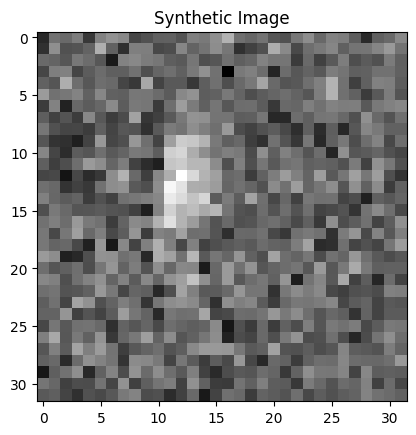

In [32]:
image = synthetic_data[0].cpu().numpy()
image = image.squeeze()
plt.imshow(image, cmap='gray')
plt.title('Synthetic Image')
plt.show()

In [ ]:
model = CNN()
eps_model = UNet(image_channels=1, n_channels=32, ch_mults=[1, 2, 4], is_attn=[False, False, True])

diffusion_models = {}
for client_id in range(len(client_data_train)):
    eps_model = eps_model.to(device)
    diffusion_models[client_id] = DenoiseDiffusion(eps_model=eps_model, n_steps=100, device=device)

# accuracy_matrix = FedAvg(model, client_data_train, client_data_test, iterations=1000, epoch=5)
accuracy_matrix = FedAvg_with_Diffusion(model, client_data_train, client_data_test, diffusion_models, iterations=100, epoch=5)

file_name = f'CFL_MNIST_Diffsion.npy'
np.save(file_name, accuracy_matrix)

In [ ]:
def model_memory_size(model):
    param_size = 0
    grad_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
        if param.grad is not None:
            grad_size += param.grad.nelement() * param.grad.element_size()
    total_size = param_size + grad_size
    print(total_size / (1024 * 1024))

eps_model = UNet(image_channels=1, n_channels=32, ch_mults=[1, 2, 4], is_attn=[False, False, True])
model_memory_size(eps_model)